In [19]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

%matplotlib inline

In [20]:
print(f"PyTorch version: {torch.__version__}")
print(f"Numpy version: {np.__version__}")

PyTorch version: 2.1.2+cu118
Numpy version: 1.24.1


tensor([[ -7.4619,  -6.6245],
        [-10.4474,   7.6824],
        [  7.0092,   1.1889],
        [ -4.9008,   8.1152],
        [ -1.9671,  11.3213]]) tensor([2, 3, 1, 0, 0])


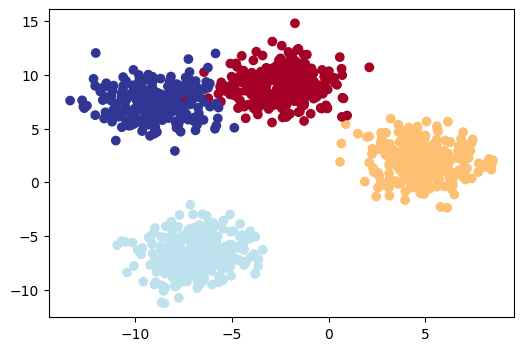

In [21]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1200,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(6, 4))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [23]:
X_blob_train.shape, X_blob_test.shape, y_blob_train.shape, y_blob_test.shape

(torch.Size([960, 2]),
 torch.Size([240, 2]),
 torch.Size([960]),
 torch.Size([240]))

In [22]:
# set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
# let's put all data into cuda
X_blob_train = X_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_train = y_blob_train.to(device)
y_blob_test = y_blob_test.to(device)

In [78]:

class BlobModelV0(nn.Module):
    def __init__(self, input_features, output_features, hidden_units, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.layer_1 = nn.Linear(in_features=input_features, out_features=hidden_units)
        self.layer_2 = nn.Linear(in_features=hidden_units, out_features=output_features)
    
    def forward(self, x):
        x = self.layer_1(x)
        #x = torch.relu(x)
        
        # Second layer (no activation here, since )
        x = self.layer_2(x)
        
        return x

In [79]:
# Create an instance of BlobModel and send it to the target device
model_0 = BlobModelV0(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_0

BlobModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=4, bias=True)
)

In [59]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [61]:
# let's define the training loop

def training_loop(X_train, y_train, X_test, y_test, loss_fn, optimizer, n_iterations, model):
    
    # Create empty loss lists to track values
    train_loss_values = []
    test_loss_values = []
    
    # Build training and evaluation loop
    for epoch in range(n_iterations):
        ### Training
        model.train()

        # 1. Forward pass (model outputs raw logits)
        y_logits = model(X_train).squeeze() 
        y_proba = torch.softmax(y_logits, dim=1)
        y_pred = y_proba.argmax(dim=1) 
    
        # 2. Calculate loss/accuracy
        loss = loss_fn(y_logits, # Using nn.CrossEntropyLoss works with raw logits
                    y_train) 
        
        
        
        acc = accuracy_fn(y_true=y_train, 
                        y_pred=y_pred) 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        ### Testing
        model.eval()
        
        with torch.inference_mode():
            # 1. Forward pass
            test_logits = model(X_test).squeeze() 
            test_proba = torch.softmax(test_logits, dim=1)
            test_pred = test_proba.argmax(dim=1)
            
            # 2. Caculate loss/accuracy
            test_loss = loss_fn(test_logits,
                                y_test)
            
            test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)

        # Print out what's happening every 50 epochs
        if (epoch % 50 == 0):
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
        
                # Save the loss values (move them to CPU before converting to NumPy)
        train_loss_values.append(loss.detach().cpu().numpy())
        test_loss_values.append(test_loss.detach().cpu().numpy())
    
    return train_loss_values, test_loss_values

In [80]:
n_iterations = 500

train_loss, test_loss = training_loop(
                                X_train=X_blob_train,
                                y_train=y_blob_train,
                                X_test=X_blob_test,
                                y_test=y_blob_test,
                                loss_fn=nn.CrossEntropyLoss(),
                                optimizer=torch.optim.SGD(
                                    params=model_0.parameters(),
                                    lr=0.01
                                ),
                                n_iterations=n_iterations, 
                                model=model_0)

Epoch: 0 | Loss: 3.36475, Accuracy: 0.00% | Test loss: 2.67069, Test acc: 0.42%

Epoch: 50 | Loss: 0.25749, Accuracy: 98.33% | Test loss: 0.23843, Test acc: 99.58%

Epoch: 100 | Loss: 0.16068, Accuracy: 98.54% | Test loss: 0.14734, Test acc: 99.58%

Epoch: 150 | Loss: 0.12165, Accuracy: 98.54% | Test loss: 0.11024, Test acc: 99.58%

Epoch: 200 | Loss: 0.10020, Accuracy: 98.54% | Test loss: 0.08992, Test acc: 99.58%

Epoch: 250 | Loss: 0.08660, Accuracy: 98.65% | Test loss: 0.07709, Test acc: 99.58%

Epoch: 300 | Loss: 0.07723, Accuracy: 98.65% | Test loss: 0.06828, Test acc: 99.58%

Epoch: 350 | Loss: 0.07039, Accuracy: 98.65% | Test loss: 0.06186, Test acc: 99.58%

Epoch: 400 | Loss: 0.06518, Accuracy: 98.75% | Test loss: 0.05698, Test acc: 99.58%

Epoch: 450 | Loss: 0.06109, Accuracy: 98.75% | Test loss: 0.05316, Test acc: 99.58%



In [31]:
def plot_loss_curves(epochs, train_loss_values, test_loss_values):
    # Create a figure with size 6x4 inches
    plt.figure(figsize=(6, 4))
    
    # Plot the training and test loss values
    plt.plot(range(epochs), train_loss_values, label="Train loss")
    plt.plot(range(epochs), test_loss_values, label="Test loss")
    
    # Set the title and labels
    plt.title("Training and Test Loss Curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    
    # Add a legend
    plt.legend()
    
    # Add a grid
    plt.grid(True)
    
    # Display the plot
    plt.show()

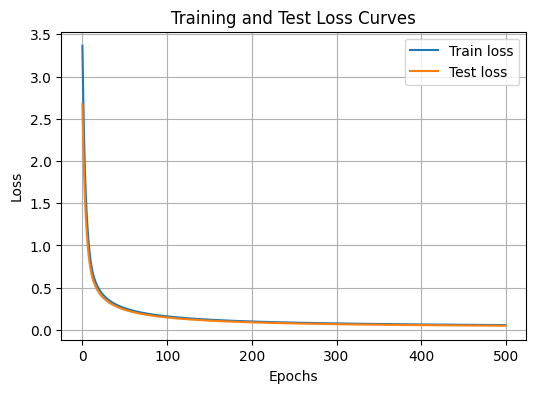

In [81]:
plot_loss_curves(epochs=n_iterations, train_loss_values=train_loss,
                    test_loss_values=test_loss)

In [64]:
y_test_logits = model_0(X_blob_test)
y_test_proba = torch.softmax(y_test_logits, dim=1)
y_test_proba[:5]

tensor([[3.1766e-03, 7.1573e-05, 1.5784e-03, 9.9517e-01],
        [9.2897e-01, 1.1445e-02, 9.9131e-04, 5.8596e-02],
        [1.1901e-02, 1.4508e-04, 1.3196e-03, 9.8663e-01],
        [5.3091e-03, 9.9358e-01, 1.0017e-03, 1.1273e-04],
        [1.3573e-02, 9.8435e-01, 1.7389e-03, 3.3720e-04]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [65]:
y_test_logits.shape

torch.Size([240, 4])

In [66]:
y_test_logits[:5]

tensor([[-1.5323e+00, -5.3252e+00, -2.2317e+00,  4.2148e+00],
        [ 2.7669e+00, -1.6296e+00, -4.0759e+00,  3.5128e-03],
        [-7.5597e-01, -5.1630e+00, -2.9552e+00,  3.6617e+00],
        [ 3.7094e-01,  5.6028e+00, -1.2968e+00, -3.4812e+00],
        [ 5.6620e-01,  4.8501e+00, -1.4886e+00, -3.1289e+00]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [67]:
torch.argmax(y_test_proba[0, :])

tensor(3, device='cuda:0')

In [68]:
y_pred = y_test_proba.argmax(dim=1)
y_pred

tensor([3, 0, 3, 1, 1, 0, 3, 1, 1, 3, 3, 1, 2, 3, 3, 1, 3, 1, 0, 1, 3, 1, 0, 1,
        1, 0, 0, 0, 3, 2, 1, 2, 3, 0, 0, 0, 3, 3, 0, 3, 2, 2, 2, 1, 0, 1, 3, 0,
        1, 2, 1, 3, 0, 1, 2, 2, 1, 0, 2, 1, 2, 3, 2, 1, 0, 2, 2, 2, 1, 3, 3, 0,
        0, 2, 3, 3, 2, 2, 3, 2, 3, 0, 3, 1, 1, 3, 2, 2, 1, 0, 1, 0, 1, 0, 2, 2,
        1, 3, 0, 1, 3, 1, 1, 0, 1, 0, 1, 2, 2, 0, 1, 1, 1, 2, 3, 3, 2, 2, 2, 2,
        3, 0, 3, 0, 3, 3, 2, 3, 1, 1, 0, 3, 0, 2, 2, 2, 3, 1, 3, 2, 2, 0, 0, 0,
        0, 1, 0, 0, 0, 3, 2, 2, 1, 2, 1, 1, 3, 3, 1, 0, 3, 3, 2, 0, 2, 1, 0, 0,
        2, 1, 2, 3, 1, 0, 2, 0, 3, 0, 2, 0, 0, 2, 2, 0, 2, 1, 2, 3, 3, 1, 0, 2,
        0, 0, 3, 0, 3, 2, 3, 3, 0, 3, 0, 0, 1, 3, 3, 1, 3, 2, 3, 3, 0, 3, 2, 2,
        3, 3, 3, 0, 3, 3, 0, 3, 2, 2, 1, 1, 2, 3, 2, 3, 1, 0, 3, 2, 0, 0, 1, 1],
       device='cuda:0')

In [69]:
accuracy_fn(y_blob_test, y_pred)

99.58333333333333

In [70]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.1152, -0.0624],
                      [-0.4723, -0.7502],
                      [ 0.6657,  0.0562],
                      [-0.6610, -0.1302],
                      [-0.2914,  0.8287],
                      [-0.1540,  0.1152],
                      [ 0.6531,  0.8238],
                      [ 0.4830,  0.2143]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.5955, -0.2458,  0.4692, -0.1956,  0.4592,  0.1734, -0.6533,  0.6069],
                     device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.1837, -0.0977, -0.2993, -0.5434,  0.2044,  0.0714,  0.4537, -0.1703],
                      [-0.2064, -0.1407,  0.6746, -0.1462, -0.3747, -0.3037,  0.4995,  0.2484],
                      [ 0.2639,  0.4094, -0.0121,  0.3777, -0.5055, -0.0397, -0.0443, -0.1417],
                      [-0.0426, -0.3414, -0.2646,  0.4934,  0.1093,  0.1251, -0.2877, -0.2586]],
                     device='c

In [71]:
from helper_functions import plot_predictions, plot_decision_boundary

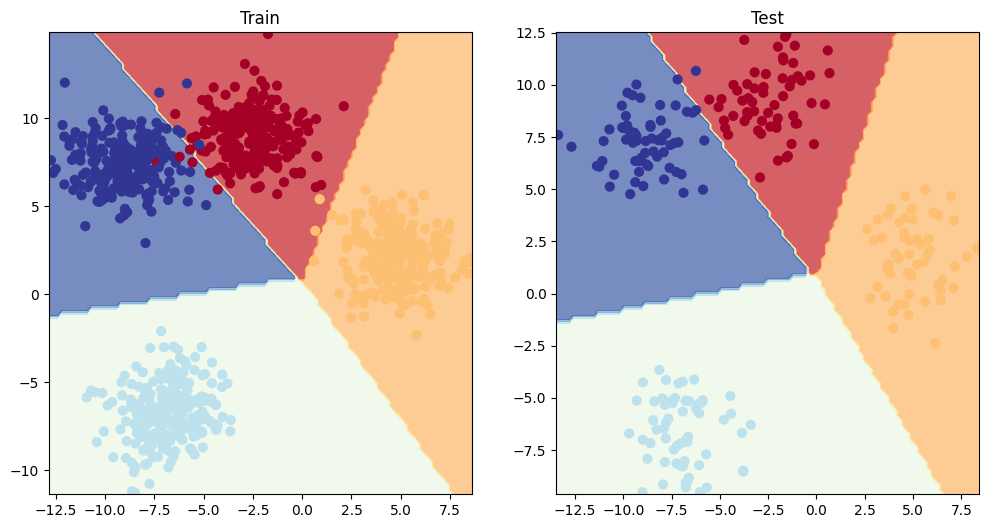

In [82]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_blob_test, y_blob_test)

In [83]:
# using nn.Sequencial()

class BlobModelV1(nn.Module):
    
    def __init__(self, input_features, output_features, hidden_units, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
            
        )
    
    def forward(self, x):
        x = self.linear_layer_stack(x)
        
        return x

In [88]:
# Create an instance of BlobModel and send it to the target device
model_1 = BlobModelV1(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_1

BlobModelV1(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [89]:
model_1.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[-0.5669, -0.2269],
                      [-0.2779,  0.6069],
                      [ 0.4166, -0.4851],
                      [ 0.3757, -0.0653],
                      [-0.5917, -0.1726],
                      [ 0.0565,  0.1618],
                      [-0.4930, -0.5902],
                      [ 0.6201, -0.3097]], device='cuda:0')),
             ('linear_layer_stack.0.bias',
              tensor([ 0.0585, -0.3977, -0.6031, -0.3997,  0.1958,  0.0320,  0.6795,  0.5403],
                     device='cuda:0')),
             ('linear_layer_stack.2.weight',
              tensor([[-0.1255,  0.2754, -0.2158, -0.3191, -0.0826, -0.0643,  0.2105,  0.1212],
                      [-0.1797,  0.3069,  0.1037, -0.1190, -0.2335, -0.2867,  0.2205,  0.1224],
                      [ 0.2997,  0.1127, -0.0830, -0.0927, -0.2966, -0.1822,  0.0410, -0.0487],
                      [ 0.1198,  0.2668, -0.1587,  0.0676,  0.2999, -0.1871,  0.1857, -0

In [91]:
n_iterations = 400

train_loss, test_loss = training_loop(
                                X_train=X_blob_train,
                                y_train=y_blob_train,
                                X_test=X_blob_test,
                                y_test=y_blob_test,
                                loss_fn=nn.CrossEntropyLoss(),
                                optimizer=torch.optim.SGD(
                                    params=model_1.parameters(),
                                    lr=0.01
                                ),
                                n_iterations=n_iterations, 
                                model=model_1)

Epoch: 0 | Loss: 1.50771, Accuracy: 53.23% | Test loss: 1.28534, Test acc: 62.50%

Epoch: 50 | Loss: 0.34640, Accuracy: 97.92% | Test loss: 0.31200, Test acc: 99.58%

Epoch: 100 | Loss: 0.21347, Accuracy: 98.02% | Test loss: 0.18774, Test acc: 99.58%

Epoch: 150 | Loss: 0.15252, Accuracy: 98.23% | Test loss: 0.13226, Test acc: 99.58%

Epoch: 200 | Loss: 0.11956, Accuracy: 98.54% | Test loss: 0.10274, Test acc: 99.58%

Epoch: 250 | Loss: 0.09946, Accuracy: 98.54% | Test loss: 0.08498, Test acc: 99.58%

Epoch: 300 | Loss: 0.08611, Accuracy: 98.54% | Test loss: 0.07331, Test acc: 99.58%

Epoch: 350 | Loss: 0.07669, Accuracy: 98.54% | Test loss: 0.06514, Test acc: 99.58%



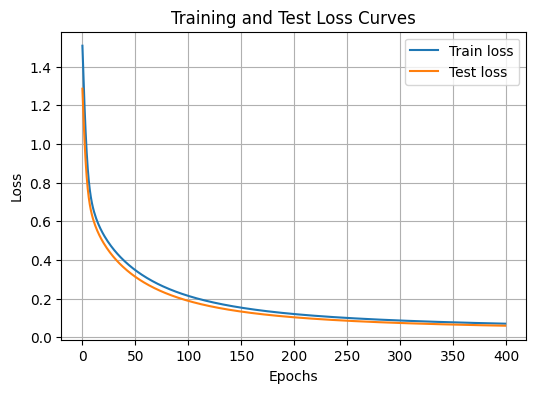

In [92]:
plot_loss_curves(epochs=n_iterations, train_loss_values=train_loss,
                    test_loss_values=test_loss)

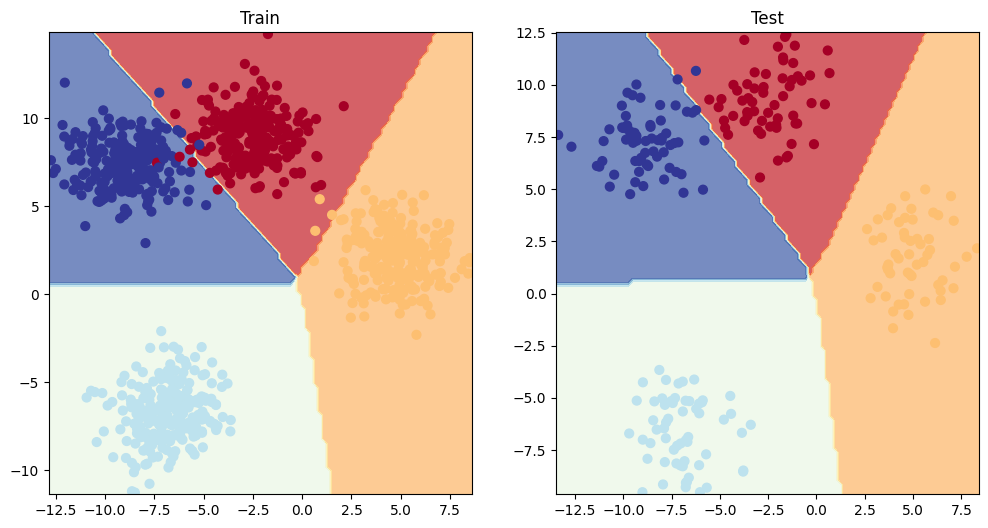

In [93]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_blob_test, y_blob_test)